# Miniprojeto MLP

### Grupo:
#### - Caio Rocha Calado
#### - Gabriel Ayres Barbosa
#### - Emanoel Thyago Cordeiro dos Santos
#### - Mateus Araújo Neves
#### - Rafael Ramos Batista Corcino

# Importando as Bibliotecas

In [659]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import resample
import torch.nn.init as init

# Análise Inicial dos Dados

In [660]:
# Carregando os arquivos
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
target_test = pd.read_csv('/content/gender_submission.csv')

In [661]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [662]:
print(train_df.nunique())

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


# Pré-processamento dos Dados

In [663]:
# Removendo colunas irrelevantes ou com muitos valores únicos
train_df = train_df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1)

# Preenchendo valores ausentes na coluna 'Age' com a média
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

# Removendo linhas restantes com valores ausentes
train_df = train_df.dropna()

# Convertendo variáveis categóricas para variáveis dummy (one-hot encoding)
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])

# Garantindo que todos os dados sejam do tipo float
train_df = train_df.astype(float)

In [664]:
# Separar as classes
df_majority = train_df[train_df['Survived'] == 0.0]
df_minority = train_df[train_df['Survived'] == 1.0]

# Aplicar Oversampling na classe minoritária
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Permite duplicação
                                 n_samples=len(df_majority),  # Igualar ao tamanho da maioria
                                 random_state=42)

# Combinar os datasets balanceados
train_df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verificar se ficou balanceado
print(train_df_balanced['Survived'].value_counts())

Survived
0.0    549
1.0    549
Name: count, dtype: int64


In [665]:
# Separar features e target
features = train_df_balanced.drop(columns=['Survived'])
target = train_df_balanced['Survived']

In [666]:
# Normalização
minmax_scaler = MinMaxScaler()
features_minmax = pd.DataFrame(minmax_scaler.fit_transform(features), columns=features.columns)

print("\nMinMaxScaler:")
print(features_minmax.head())


MinMaxScaler:
   Pclass       Age  SibSp     Parch      Fare  Sex_female  Sex_male  \
0     1.0  0.271174  0.125  0.000000  0.014151         0.0       1.0   
1     1.0  0.434531  0.000  0.000000  0.015713         0.0       1.0   
2     1.0  0.367921  0.000  0.000000  0.016510         0.0       1.0   
3     0.0  0.673285  0.000  0.000000  0.101229         0.0       1.0   
4     1.0  0.019854  0.375  0.166667  0.041136         0.0       1.0   

   Embarked_C  Embarked_Q  Embarked_S  
0         0.0         0.0         1.0  
1         0.0         0.0         1.0  
2         0.0         1.0         0.0  
3         0.0         0.0         1.0  
4         0.0         0.0         1.0  


# Modelo

In [667]:
class MLP(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Sigmoid(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Inicialização Xavier
        self.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)  # Inicialização Xavier Uniforme
            if m.bias is not None:
                m.bias.data.fill_(0)  # Inicializa os bias com 0

In [668]:
# Convertendo as features para um tensor do PyTorch
features_train = torch.tensor(features_minmax.to_numpy(), dtype=torch.float32)

# Convertendo o target para um tensor do PyTorch e adicionando uma dimensão extra
target_train = torch.tensor(target.to_numpy(), dtype=torch.float32).unsqueeze(1)

In [669]:
# Definindo KFold para 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Armazenando os resultados
accuracies = []

# Cross-validation
bestModel = None
bestAccuracy = 0

for train_idx, val_idx in kf.split(features_train):
    # Separando dados de treino e validação
    X_train, X_val = features_train[train_idx], features_train[val_idx]
    y_train, y_val = target_train[train_idx], target_train[val_idx]

    # Criar modelo e otimizar
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Treinamento
    epochs = 100
    for epoch in range(epochs):
        model.train()  # Coloca o modelo em modo de treino
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # Avaliação no conjunto de validação
    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_accuracy = ((y_val_pred.round() == y_val).float().mean()).item()

    accuracies.append(val_accuracy)
    print(f"Fold - Acurácia de Validação: {val_accuracy:.4f}")

    if bestModel == None or val_accuracy > bestAccuracy:
        bestAccuracy = val_accuracy
        bestModel = model

# Resultado final: Média das acurácias nos folds
mean_accuracy = np.mean(accuracies)
print(f"\nAcurácia média da cross-validation: {mean_accuracy:.4f}")

Fold - Acurácia de Validação: 0.8091
Fold - Acurácia de Validação: 0.7682
Fold - Acurácia de Validação: 0.7545
Fold - Acurácia de Validação: 0.7626
Fold - Acurácia de Validação: 0.8219

Acurácia média da cross-validation: 0.7833


# Testando o melhor modelo no conjunto de teste:

In [670]:
test_df = test_df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1)

test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

# Substituir NaN pela moda na coluna 'Fare'
mode_fare = test_df['Fare'].mode()[0]  # Obtém a moda (valor mais frequente) da coluna 'Fare'
test_df['Fare'] = test_df['Fare'].fillna(mode_fare)  # Substitui os NaN pela moda

test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])

test_df = test_df.astype(float)
features_minmax_test = pd.DataFrame(minmax_scaler.transform(test_df), columns=test_df.columns)
target_test = target_test['Survived']

features_test = torch.tensor(features_minmax_test.to_numpy(), dtype=torch.float32)
target_test = torch.tensor(target_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

In [671]:
bestModel.eval()

# Realizar previsões
with torch.no_grad():  # Desabilitar o cálculo de gradientes para não consumir memória desnecessária
    predictions = bestModel(features_test)

# Como o modelo é para classificação binária (presumido pela saída de uma única unidade), podemos arredondar as previsões
predictions = predictions.round().numpy()

# Calcular as métricas de avaliação
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, predictions)

# Exibir as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Acurácia: 0.9187
Precisão: 0.8172
Recall: 1.0000
F1-Score: 0.8994
AUC-ROC: 0.9361


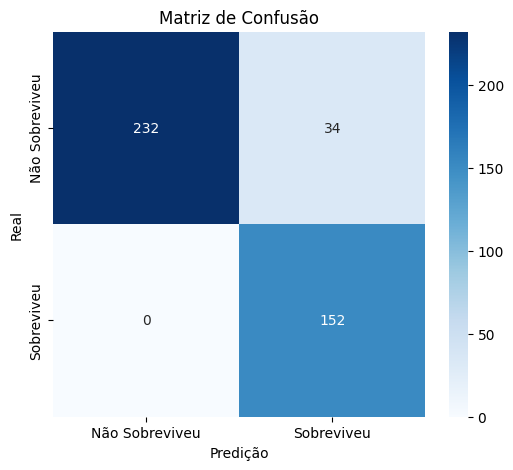

In [672]:
# Calcular a matriz de confusão
cm = confusion_matrix(target_test, predictions)

# Exibir a matriz de confusão como um gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobreviveu', 'Sobreviveu'], yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()